# Label Exploration

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#usual stuff
from datetime import datetime
import random
import math
from collections import Counter, namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
import glob
import shutil
import warnings
warnings.filterwarnings("ignore")

#fastai
import fastai
from fastai import *          # Quick accesss to most common functionality
from fastai.vision import *   # Quick accesss to computer vision functionality

#paths
DATA_PATH = '~/.kaggle/competitions/human-protein-atlas-image-classification/'
TRAIN_PATH = f'{DATA_PATH}train/'

#constants
itol = ['Nucleoplasm', 
        'Nuclear membrane',   
        'Nucleoli',
        'Nucleoli fibrillar center',
        'Nuclear speckles',   
        'Nuclear bodies',   
        'Endoplasmic reticulum',
        'Golgi apparatus',   
        'Peroxisomes',   
        'Endosomes',   
        'Lysosomes',   
        'Intermediate filaments',   
        'Actin filaments',   
        'Focal adhesion sites',   
        'Microtubules',   
        'Microtubule ends',   
        'Cytokinetic bridge',   
        'Mitotic spindle',   
        'Microtubule organizing center',   
        'Centrosome',   
        'Lipid droplets',   
        'Plasma membrane',   
        'Cell junctions',   
        'Mitochondria',   
        'Aggresome',   
        'Cytosol',   
        'Cytoplasmic bodies', 
        'Rods & rings']

#check cuda
print(f'PyTorch version {torch.version.__version__}')
print(f'CUDA is {torch.cuda.is_available()}')
print(f'CuDnn is {torch.backends.cudnn.enabled}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch version 1.0.0.dev20180929
CUDA is False
CuDnn is True


device(type='cpu')

## Problem

* **Objective** multi-label classification (28 labels)
* **Sample size** 31,072 examples (4 images each)
* **Image size** 512x512 PNG (full size being a mix of 2048x2048 and 3072x3072 TIFF files)
* **Scoring metric** Macro-F1

## Possible Challenges

* **Loss function** macro-F1 means misclassification of rare labels has disproportional weight to their number of examples. Loss functions that penalize misclassifying "more difficult" examples more such as [focal loss](https://arxiv.org/abs/1708.02002).
* **Four channels** pretrained models usually have three channels but our data has four. Since the images are vastly different from ImageNet anyways, we might want to try 
    * modify first layer of pretrained models to take 4-channel input and initialize that layer with random weights
    * starting with random weights and four-channel input first
    * training one model for each channel and ensemble later

## Exploration

In [2]:
meta = pd.read_csv(f'{DATA_PATH}train.csv')
meta.describe()[:2]

,Id,Target
count,31072,31072
unique,31072,582


In [3]:
meta.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [5]:
#initialize ohe
for col_name in itol:
    meta[col_name] = 0

#insert lab
def insert_lab(row):
    target_list = row['Target'].split()
    for i in target_list:
        col_name = itol[int(i)]
        row.loc[col_name] = 1
    return(row)

meta = meta.apply(insert_lab, axis=1)
meta['nb_labels'] = meta.iloc[:,2:].sum(axis=1)
meta.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings,nb_labels
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Number of Labels per Sample

In [35]:
nb_labels_df = meta.loc[:,['nb_labels','Id']].groupby('nb_labels').count().reset_index()
nb_labels_df['per_labels'] = nb_labels_df['Id'] / sum(nb_labels_df.Id)

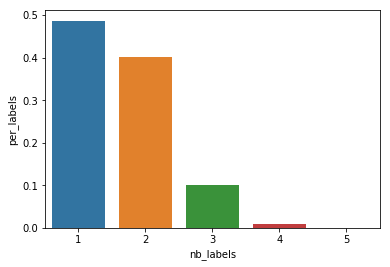

In [39]:
sns.barplot(x='nb_labels',y='per_labels',data=nb_labels_df)

### Label Distribution

In [63]:
labels_df = meta.iloc[:,2:-1].sum(axis=0).reset_index()
labels_df.columns = ['labels','nb_ids']
labels_df['per_ids'] = labels_df.nb_ids / sum(labels_df.nb_ids)
labels_df.sort_values('per_ids',ascending=False,inplace=True)

In [64]:
labels_df.head()

,labels,nb_ids,per_ids
0,Nucleoplasm,12885,0.253732
25,Cytosol,8228,0.162026
21,Plasma membrane,3777,0.074377
2,Nucleoli,3621,0.071305
23,Mitochondria,2965,0.058387


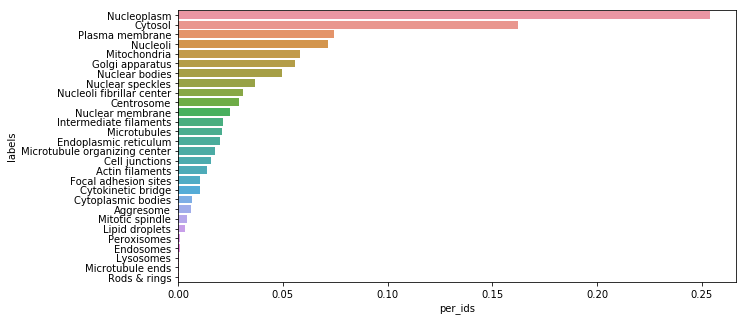

In [70]:
plt.figure(figsize=(10,5))
sns.barplot(x='per_ids',y='labels',data=labels_df)

### Label Correlation

In [78]:
corr_df = meta[meta.nb_labels>1].iloc[:,2:-1]

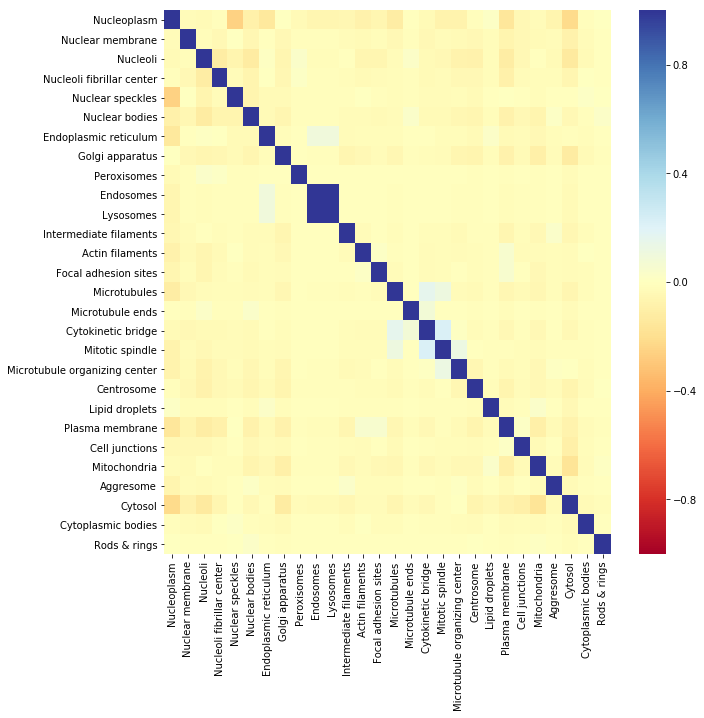

In [86]:
plt.figure(figsize=(10,10))
sns.heatmap(cor_df.corr(), cmap="RdYlBu", vmin=-1, vmax=1)

## Sample Images